In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os import path
import pickle

In [7]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 100
# Количество классов новостей
nb_classes = 10

In [8]:
def put_content(files, directory):
    for file_name in files:
        ids.append(int(file_name.replace(".txt", "").split("_")[0]))
        grades.append(int(file_name.replace(".txt", "").split("_")[1]))
        texts.append(open(path.join(directory, file_name), 'r').read())

In [9]:
# Подготовка тренировочного набора
ids = []
grades = []
texts = []

train_neg_dir = "aclImdb/train/neg"
train_pos_dir = "aclImdb/train/pos"

train_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_neg_dir)))
train_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_pos_dir)))

put_content(train_neg_files, train_neg_dir)
put_content(train_pos_files, train_pos_dir)

train_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

train_df = train_df.iloc[np.random.permutation(len(train_df))].reset_index(drop=True)

In [10]:
# Подготовка тестового набора
ids = []
grades = []
texts = []

test_neg_dir = "aclImdb/test/neg"
test_pos_dir = "aclImdb/test/pos"

test_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_neg_dir)))
test_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_pos_dir)))

put_content(test_neg_files, test_neg_dir)
put_content(test_pos_files, test_pos_dir)

test_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

test_df = test_df.iloc[np.random.permutation(len(test_df))].reset_index(drop=True)

In [13]:
# Создание токенайзера
tokenizer = Tokenizer(num_words=num_words)

In [58]:
# Тренировка tokenizer
tokenizer.fit_on_texts(train_df['text'])

In [16]:
# Сохранение обученного tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# Преобразование текста в последовательности чисел
sequences = tokenizer.texts_to_sequences(train_df['text'])


In [20]:
# Ограничить длину отзыва
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [15]:
# Сверточная нейронная сеть

In [31]:
# Создание самой модели
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_news_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [32]:
# Компиляция модели
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 250)           40250     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 92, 250)           312750    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 88, 250)           312750    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 84, 250)           312750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [33]:
# Сохренение модели
model.save('model_categorical')

INFO:tensorflow:Assets written to: model_categorical/assets


In [34]:
# Создаем callback для сохранения нейронной сети на каждой эпохе,
    # если качество работы на проверочном наборе данных улучшилось.
# Сеть сохраняется в файл best_model_categorical.h5
model_save_path = 'best_model_categorical.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [35]:
# Правильные ответы
y_train = utils.to_categorical(train_df['grade'] - 1, nb_classes)

In [36]:
history = model.fit(x_train, 
                            y_train, 
                            epochs=3,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/3
176/176 [==============================] - ETA: 0s - loss: 1.9920 - accuracy: 0.2316
Epoch 00001: val_accuracy improved from -inf to 0.31240, saving model to best_model_categorical.h5
176/176 [==============================] - 156s 885ms/step - loss: 1.9920 - accuracy: 0.2316 - val_loss: 1.8330 - val_accuracy: 0.3124
Epoch 2/3
176/176 [==============================] - ETA: 0s - loss: 1.7074 - accuracy: 0.3455
Epoch 00002: val_accuracy improved from 0.31240 to 0.35600, saving model to best_model_categorical.h5
176/176 [==============================] - 153s 868ms/step - loss: 1.7074 - accuracy: 0.3455 - val_loss: 1.7049 - val_accuracy: 0.3560
Epoch 3/3
176/176 [==============================] - ETA: 0s - loss: 1.5065 - accuracy: 0.4079
Epoch 00003: val_accuracy improved from 0.35600 to 0.36840, saving model to best_model_categorical.h5
176/176 [==============================] - 151s 860ms/step - loss: 1.5065 - accuracy: 0.4079 - val_loss: 1.6288 - val_accuracy: 0.3684


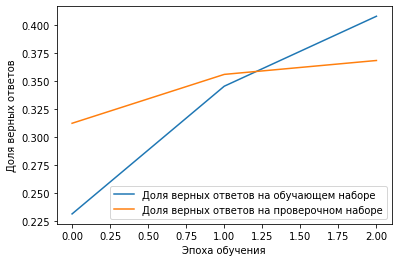

In [38]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [39]:
# Тестирование работы

In [40]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [41]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [43]:
y_test = utils.to_categorical(test_df['grade'] - 1, nb_classes)

In [45]:
# Качество Одномерная сверточная сеть

In [59]:
from tensorflow import keras
model_categorical = keras.models.load_model('model_categorical')
model_categorical_save_path = 'best_model_categorical.h5'
model_categorical.load_weights(model_categorical_save_path)

In [60]:
# Определение доли верных ответов на тестовом наборе
model_cnn.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 45s 58ms/step - loss: 1.6310 - accuracy: 0.3748


[1.6310148239135742, 0.37483999133110046]

In [61]:
# Оцениваем тональность на собственном отзыве
# Загрузка обученного tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [62]:
text = """
good
"""

In [63]:
sequence = tokenizer.texts_to_sequences([text])

In [64]:
data = pad_sequences(sequence, maxlen=max_news_len)

In [65]:
result = list(model_cnn.predict(data)[0])

In [66]:
print('Кол-во звезд отзыва', result.index(max(result)) + 1)

Кол-во звезд отзыва 8


In [67]:
if result.index(max(result)) < 5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

Отзыв положительный
